In [2]:
import pandas as pd
from pathlib import Path
from loader import get_subfolders, load_multiple_timings_scalability, load_multiple_timings_scalability

In [3]:
plot_data = pd.DataFrame()
plot_data_path = Path('../measurements/scalability/data.csv')
loaded_plot_data = False

if plot_data_path.is_file():
    plot_data = pd.read_csv(plot_data_path)
    loaded_plot_data = True
    print("USING PERSISTED CSV")
else:
  folders = get_subfolders(Path("../measurements/scalability/nlpkkt240-shuffled"))
  folders += get_subfolders(Path("../measurements/scalability/nlpkkt240"))
  folders += get_subfolders(Path("../measurements/scalability/HV15R"))
  folders += get_subfolders(Path("../measurements/scalability/stokes"))
  folders += get_subfolders(Path("../measurements/scalability/nlpkkt200"))
  # folders = [folder for folder in folders if load_algorithm(folder) == 'drop_parallel']
  # Returns the matrix name and a dictionary of ma pping from function to dataframe
  ft = load_multiple_timings_scalability(folders)

USING PERSISTED CSV


In [4]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np

SCALING_FACTOR = 10**9 # for seconds
# SCALING_FACTOR = 10**6
runs = 50
plt.rcParams['font.family'] = 'Computer Modern Roman'
plt.rcParams['text.usetex'] = True

plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
STYLES = {
    # color, marker, offst, name
    "stokes": ('darkcyan', 'h', (-60, -20), "\\textsc{NHWC}", None),
    "HV15R": ('dodgerblue', 'h', (-60, -20), "\\textsc{NHWC}", None),
    "nlpkkt240-shuffled": ('', 'h', (-60, -20), "\\textsc{NHWC}", None),
    "nlpkkt240": ('deeppink', 'h', (-60, -20), "\\textsc{NHWC}", None),
    "nlpkkt200": ('blueviolet', 'h', (-75, -15), "\\textsc{Merged}", None),
    # "todo3": ('brown', '^', (-210, -135), "\\textsc{Tensor Macro}", 26),
    # "todo5": ('darkolivegreen', 's', (-120, -118), "\\textsc{Merged+Blocked}", None),
}

Text(0.5, 1.0, 'Squaring computation on multiple matrices')

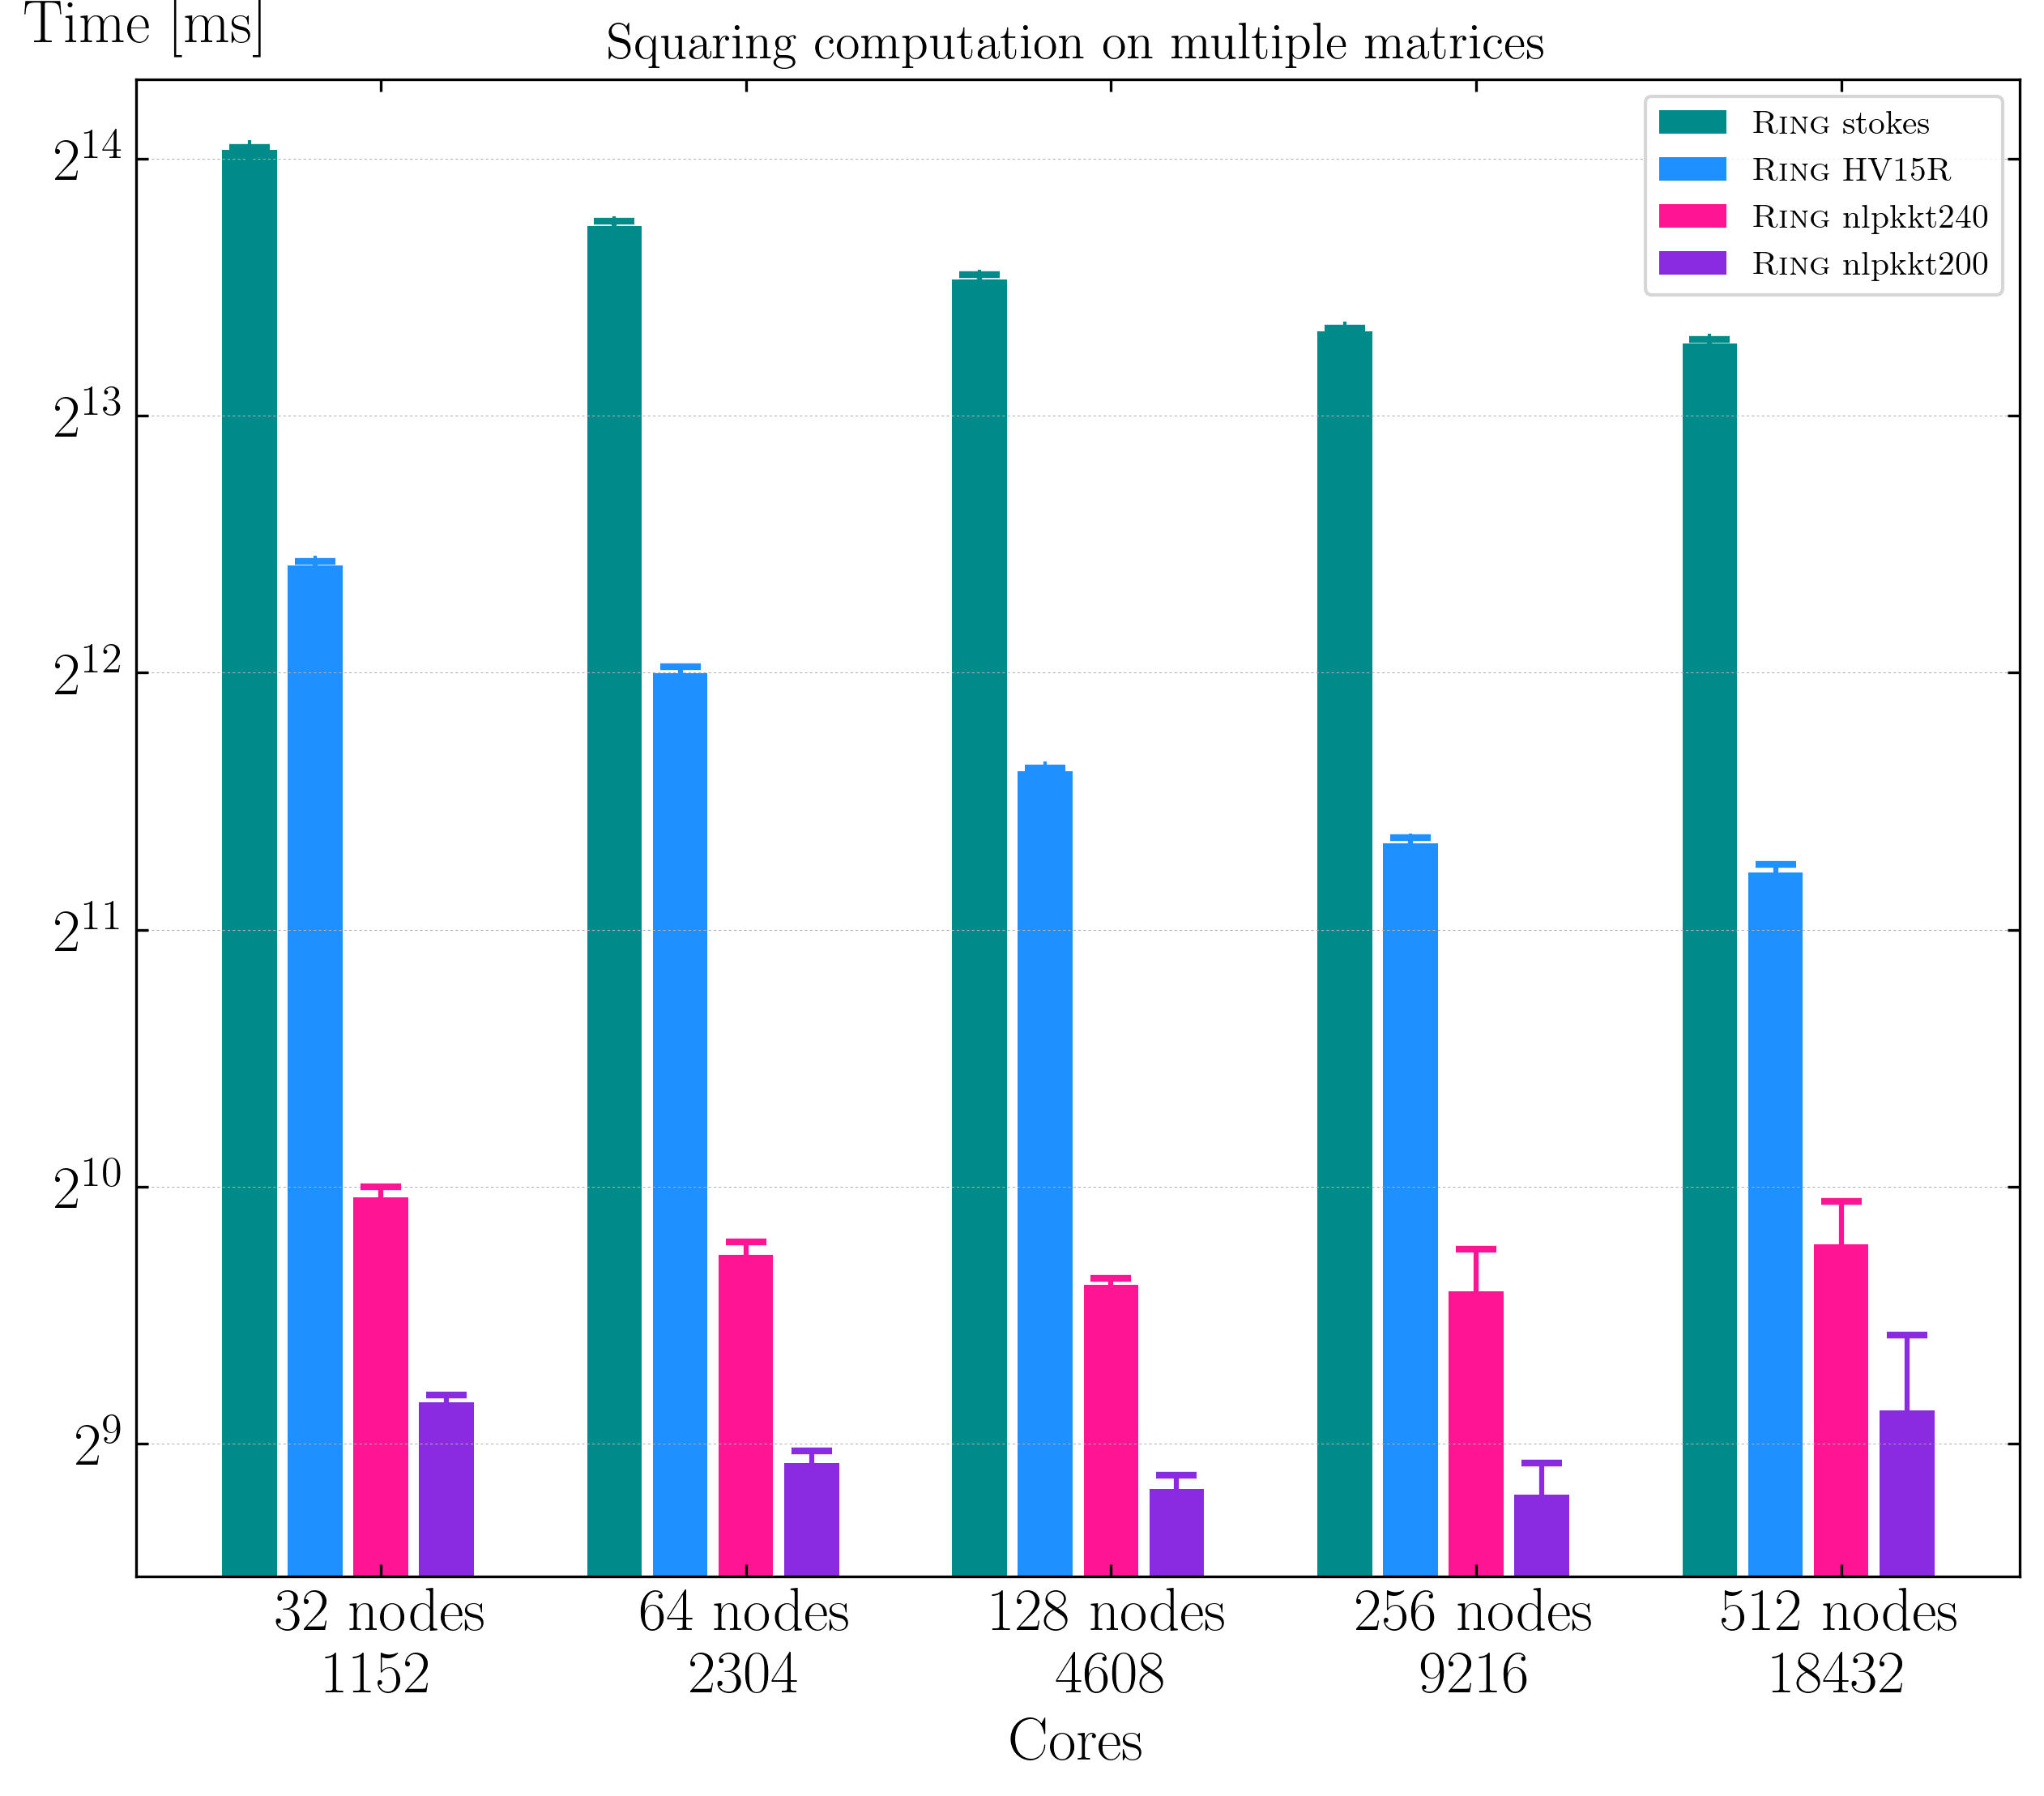

In [8]:
fig = plt.figure(figsize=(10, 8), dpi=300)
ax = fig.add_subplot()

width = 0.15
x_offset = 0

tick_keysi = None
mid_point_algo = 'nlpkkt240'
configs = (('stokes', '\\textsc{Ring} stokes'), ('HV15R', '\\textsc{Ring} HV15R'), ('nlpkkt240', '\\textsc{Ring} nlpkkt240'), ('nlpkkt200', '\\textsc{Ring} nlpkkt200'))
for algo, pretty_name in configs:
# for algo, pretty_name in (('HV15R', 'DropParallel HV15R'), ('nlpkkt240', 'DropParallel nlpkkt240'), ('nlpkkt200', 'DropParallel nlpkkt200')):
    timings = []

    if loaded_plot_data:
        timings = plot_data[plot_data["algo"] == algo]
    else:
        timings = ft[algo]
        func_data = timings[timings["func"] == 'gemm']
        for key, group in func_data.groupby('mpi'):
            value = group["duration"]
            avg = value.mean()/SCALING_FACTOR
            timings.append({
                "key": key,
                "avg": avg,
                "min": min(value.quantile(0.025)/SCALING_FACTOR, avg),
                "max": max(value.quantile(0.975)/SCALING_FACTOR, avg)
            })

        timings = pd.DataFrame(timings)
        timings["algo"] = algo
        plot_data = pd.concat([plot_data, timings])

    # print(timings)
    # Calculate the error bars
    eb = [
        (timings['avg'] - timings['min']),
        (timings['max'] - timings['avg'])
    ]

    keys = timings["key"]
    keysi = [i+x_offset for i in range(len(keys))]
    x_offset += width + 0.03
    values = timings["avg"]
    color, marker, offst, name, rotation = STYLES[algo]
    ax.bar(keysi, values, width, label=pretty_name, color=color)
    ax.errorbar(keysi, values, yerr=eb, fmt='|', capsize=6, capthick=2, color=color)

    if algo == mid_point_algo: tick_keysi = keysi

if tick_keysi == None: tick_keysi = keysi
ax.set_xlabel("Cores")
ax.set_ylabel('Time [ms]',
            rotation='horizontal',
            loc='top')
ax.yaxis.set_label_coords(0.07, 1.015) 
ax.set_xticks(tick_keysi, labels=[f"{mpi} nodes\n{mpi * 36}"for mpi in keys])

plt.yscale('log', base=2)
ax.tick_params(axis='both', direction='in', which='major')
ax.grid(which='major', axis='y', linewidth=.25, dashes=(3,3))
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

ax.legend()
ax.set_title("Squaring computation on multiple matrices", fontsize=15)

In [6]:
# save df to avoid reloading measurements
if not loaded_plot_data:
  plot_data.to_csv(plot_data_path, index=False)

In [10]:
fig.savefig("scalability.pdf", bbox_inches="tight")